# Source Code Analysis

## Initialization

In [1]:
import os
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
        sys.path.append(path)    
add_path('/home/jjian03/anaconda3/lib/python3.7/site-packages')
add_path(f'{os.path.abspath(os.path.join("."))}/lib')


### Load Data

In [2]:
from lib.Repository import *
from lib.Utility import *
from lib.modeling import *
from lib.preprocessing import *
from lib.preprocessing.HTMLParser import html_parser
from lib.viz import *

Allocated 16 CPUs


In [3]:
import time
import datetime
start_time = time.time()
raw_data = DataSource(truncated=False).raw_data

raw_data.info()

print(f'raw_data: {shape(raw_data)}')

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

Sample Size - raw_data: 14673
Initialized
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14673 entries, 0 to 14672
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      14673 non-null  object 
 1   url                                     14673 non-null  object 
 2   actual_scrape_url                       14673 non-null  object 
 3   first_appear                            14673 non-null  int64  
 4   first_available_timestamp               0 non-null      float64
 5   last_available_timestamp                14673 non-null  int64  
 6   header                                  14673 non-null  object 
 7   html_text                               14673 non-null  object 
 8   comment                                 14673 non-null  object 
 9   from_waybackmachine                     14673 non-null  int64  
 10  http_status_code

### Train Test Split

In [4]:
start_time = time.time()

train_data = DataSource().train_data
test_data = DataSource().test_data


print('Shape of the dataframe:')
print(f'train_data: {shape(train_data)}')
print(f'test_data: {len(test_data)}')

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

Shape of the dataframe:
train_data: (10271, 36)
test_data: 4402
--- 00 minutes, 0.00 seconds ---


In [5]:
display(pd.DataFrame({
    'unique count': print_unique_count(train_data),
    'na count': print_na_count(train_data)
}, index=train_data.columns))

unique count  na count
id                                              9828         0
url                                             9828         0
actual_scrape_url                               9799         0
first_appear                                      22         0
first_available_timestamp                          1     10271
last_available_timestamp                        9795         0
header                                          9828         0
html_text                                       7155         0
comment                                         2267         0
from_waybackmachine                                2         0
http_status_code                                   2         0
original_check_failure                             2         0
original_check_error_log                          37         0
terminate_reason                                   1         0
terminate_reason_error_log                         1         0
paperId                                         9447         0
total_num_of_paper_citing                        258       306
total_num_of_author_citing                      1087       306
total_num_of_affiliation_citing                  423       389
total_num_of_journal_citing                      246       347
total_num_of_author_self_citation                 60      2805
total_num_of_affiliation_self_citation            59      4013
total_num_of_journal_self_citation                35      5672
avg_year                                        5907       306
min_year                                         179       306
max_year                                          36       306
median                                            52      5288
num_of_author                                     68      2021
num_of_author_citing                             932       306
num_of_affiliation_citing                        291       389
num_of_journal_citing                            136       347
avg_hindex                                      1521       197
first_author_hindex                               96      1478
last_author_hindex                                96      1478
avg_mid_author_hindex                           1293      1881
paper_unique_affiliation                          38      2021

## Modeling

### Elastic Net Regression

#### 1st Edition - Combine suffix dummy with MAG

In [6]:
from feature_engine import categorical_encoders


pipe = Pipeline([
    ('label_builder', LabelBuilder()),
    ('url_parser', URLParser()),
    ('url_length_counter', URLLengthCounter()),
    ('url_depth_counter', URLDepthCounter()),
    ('has_www_converter', HasWWWConverter()),
    ('subdomain_level_counter', SubdomainLevelCounter()),
    ('request_parameter_counter', RequestParameterCounter()),
    ('domain_suffix_builder', DomainSuffixBuilder()),
    ('incorrect_domain_url_cleaner', IncorrectDomainUrlCleaner()),
    ('column_renamer', ColumnRenamer({'scheme': 'protocol_type'})),
    ('binary_na_encoder', BinaryNAEncoder(['content_type'])),
    ('html_parser', html_parser),
    ('binary_feature_converter', FeatureValueMapper('protocol_type', {
                                        'http': 1,
                                        'https':0,
                                        })),

    ('nan_to_Zero_converter', NanToZeroConverter([
        'total_num_of_paper_citing',
        'total_num_of_author_citing',
        'total_num_of_affiliation_citing',
        'total_num_of_journal_citing',
        'total_num_of_author_self_citation',
        'total_num_of_affiliation_self_citation',
        'total_num_of_journal_self_citation',
        'avg_year',
        'min_year',
        'max_year',
        'median',
        'num_of_author',
        'num_of_author_citing',
        'num_of_affiliation_citing',
        'num_of_journal_citing',
        'avg_hindex',
        'first_author_hindex',
        'last_author_hindex',
        'avg_mid_author_hindex',
        'paper_unique_affiliation'
    ])),
    
    ('feature_picker', FeaturePicker([
                                        'protocol_type',
                                        'url_depth',
                                        'has_www',
                                        'subdomain_level',
                                        'param_cnt',
                                        'suffix_idx',
                                        'is_port_access',
                                        'code_size',
                                        'title_length',
                                        'internal_js_cnt',
                                        'external_js_cnt',
                                        'charset',
                                        'is_html5',
                                        'has_iframe',
                                        'hyperlink_cnt',

                                        'total_num_of_paper_citing',
                                        'total_num_of_author_citing',
                                        'total_num_of_affiliation_citing',
                                        'total_num_of_journal_citing',
                                        'total_num_of_author_self_citation',
                                        'total_num_of_affiliation_self_citation',
                                        'total_num_of_journal_self_citation',
                                        'avg_year',
                                        'min_year',
                                        'max_year',
                                        'median',
                                        'num_of_author',
                                        'num_of_author_citing',
                                        'num_of_affiliation_citing',
                                        'num_of_journal_citing',
                                        'avg_hindex',
                                        'first_author_hindex',
                                        'last_author_hindex',
                                        'avg_mid_author_hindex',
                                        'paper_unique_affiliation',

                                        'label',
                                       ])),
    ('dummy_suffix_descritizer', DummySuffixDescritizer()),

    ('feature_remover', FeatureRemover([
                                        'is_port_access',
                                       ])),
    ('frequency_indexer', categorical_encoders.CountFrequencyCategoricalEncoder(
        encoding_method='frequency',
        variables=['charset'])),
    ('standard_scaler', CustomizedStandardizer(norm='l2')),

])

X_train = pipe.fit_transform(DataSource().train_data)
y_train = X_train.label
X_train = X_train.drop('label', axis=1)
print(X_train.columns)

X_test = pipe.fit_transform(DataSource().test_data)
y_test = X_test.label
X_test = X_test.drop('label', axis=1)
print(X_test.columns)


train = X_train.copy()
train.loc[:,'label'] = y_train
test = X_test.copy()
test.loc[:,'label'] = y_test


Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'url_depth', 'subdomain_level', 'param_cnt', 'title_length',
       'internal_js_cnt', 'external_js_cnt', 'charset', 'hyperlink_cnt',
       'total_num_of_paper_citing', 'total_num_of_author_citing',
       'total_num_of_affiliation_citing', 'total_num_of_journal_citing',
       'total_num_of_author_self_citation',
       'total_num_of_affiliation_self_citation',
       'total_num_of_journal_self_citation', 'avg_year', 'min_year',
       'max_year', 'median', 'num_of_author', 'num_of_author_citing',
       'num_of_affiliation_citing', 'num_of_journal_citing', 'avg_hindex',
       'first_author_hindex', 'last_author_hindex', 'avg_mid_author_hindex',
       'paper_unique_affiliation'],
      dtype='object')
Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'url_depth', 'subdomain_level', 'param_cnt', 'title_length',
       'internal_js_cnt', 'externa

In [7]:
import numpy as np
from sklearn.linear_model import ElasticNet


start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 4.7%


Coefficients  Standard Errors  \
Constant                                      1.6717            0.115   
protocol_type                                 0.6063            0.087   
gov                                           0.3943            0.076   
total_num_of_paper_citing                     0.3339            0.148   
num_of_author_citing                          0.1554            0.142   
total_num_of_author_self_citation             0.0994            0.043   
total_num_of_journal_self_citation            0.0422            0.026   
total_num_of_journal_citing                   0.0098            0.163   
org                                           0.0075            0.064   
internal_js_cnt                               0.0021            0.028   
hyperlink_cnt                                 0.0017            0.027   
num_of_author                                 0.0011            0.038   
first_author_hindex                           0.0000            0.015   
min_year                                     -0.0000            0.517   
avg_year                                     -0.0000            2.707   
last_author_hindex                            0.0000            0.015   
max_year                                     -0.0000            2.389   
total_num_of_author_citing                   -0.0000            0.140   
in                                            0.0000            0.241   
has_www                                      -0.0000            0.056   
title_length                                  0.0000            0.027   
has_iframe                                   -0.0000            0.080   
cn                                           -0.0000            0.240   
eu                                           -0.0000            0.172   
int                                           0.0000            0.168   
param_cnt                                    -0.0014            0.025   
subdomain_level                              -0.0041            0.028   
median                                       -0.0168            0.025   
avg_hindex                                   -0.0281            0.036   
paper_unique_affiliation                     -0.0290            0.036   
total_num_of_affiliation_citing              -0.0526            0.129   
avg_mid_author_hindex                        -0.0561            0.033   
external_js_cnt                              -0.0599            0.028   
total_num_of_affiliation_self_citation       -0.0792            0.043   
num_of_affiliation_citing                    -0.0848            0.106   
charset                                      -0.0900            0.027   
url_depth                                    -0.2113            0.026   
num_of_journal_citing                        -0.2968            0.068   

                                        t values  Probabilities  
Constant                                  14.549          0.000  
protocol_type                              6.940          0.000  
gov                                        5.176          0.000  
total_num_of_paper_citing                  2.264          0.024  
num_of_author_citing                       1.092          0.275  
total_num_of_author_self_citation          2.315          0.021  
total_num_of_journal_self_citation         1.616          0.106  
total_num_of_journal_citing                0.060          0.952  
org                                        0.117          0.907  
internal_js_cnt                            0.077          0.939  
hyperlink_cnt                              0.065          0.948  
num_of_author                              0.029          0.977  
first_author_hindex                        0.000          1.000  
min_year                                  -0.000          1.000  
avg_year                                  -0.000          1.000  
last_author_hindex                         0.000          1.000  
max_year                                  -0.000          1.000  
tota


R^2 on Testing Set: 3.14%


Coefficients  Standard Errors  \
Constant                                      1.6717            0.168   
protocol_type                                 0.6063            0.127   
gov                                           0.3943            0.116   
total_num_of_paper_citing                     0.3339            0.303   
num_of_author_citing                          0.1554            0.147   
total_num_of_author_self_citation             0.0994            0.069   
total_num_of_journal_self_citation            0.0422            0.040   
total_num_of_journal_citing                   0.0098            0.317   
org                                           0.0075            0.097   
internal_js_cnt                               0.0021            0.042   
hyperlink_cnt                                 0.0017            0.038   
num_of_author                                 0.0011            0.075   
first_author_hindex                           0.0000            0.023   
min_year                                     -0.0000            0.742   
avg_year                                     -0.0000            4.088   
last_author_hindex                            0.0000            0.023   
max_year                                     -0.0000            3.611   
total_num_of_author_citing                   -0.0000            0.151   
in                                            0.0000            0.385   
has_www                                      -0.0000            0.085   
title_length                                  0.0000            0.042   
has_iframe                                   -0.0000            0.120   
cn                                           -0.0000            0.349   
eu                                           -0.0000            0.298   
int                                           0.0000            0.258   
param_cnt                                    -0.0014            0.038   
subdomain_level                              -0.0041            0.043   
median                                       -0.0168            0.038   
avg_hindex                                   -0.0281            0.056   
paper_unique_affiliation                     -0.0290            0.070   
total_num_of_affiliation_citing              -0.0526            0.220   
avg_mid_author_hindex                        -0.0561            0.050   
external_js_cnt                              -0.0599            0.041   
total_num_of_affiliation_self_citation       -0.0792            0.077   
num_of_affiliation_citing                    -0.0848            0.163   
charset                                      -0.0900            0.042   
url_depth                                    -0.2113            0.040   
num_of_journal_citing                        -0.2968            0.098   

                                        t values  Probabilities  
Constant                                   9.943          0.000  
protocol_type                              4.759          0.000  
gov                                        3.386          0.001  
total_num_of_paper_citing                  1.103          0.270  
num_of_author_citing                       1.054          0.292  
total_num_of_author_self_citation          1.444          0.149  
total_num_of_journal_self_citation         1.046          0.296  
total_num_of_journal_citing                0.031          0.975  
org                                        0.077          0.938  
internal_js_cnt                            0.051          0.960  
hyperlink_cnt                              0.045          0.964  
num_of_author                              0.015          0.988  
first_author_hindex                        0.000          1.000  
min_year                                  -0.000          1.000  
avg_year                                  -0.000          1.000  
last_author_hindex                         0.000          1.000  
max_year                                  -0.000          1.000  
tota

--- 00 minutes, 45.54 seconds ---


In [8]:
Visualizer.plot_distribution(pd.DataFrame({
    'residual': result_train.best_result.residual
}), "Residual Distribution", height=400)

In [9]:
residual_df_train = pd.DataFrame({
    'title': 'Training Set',
    'residual': result_train.best_result.residual,
    'prediction': result_train.best_result.pred,
})
residual_df_test = pd.DataFrame({
    'title': 'Testing Set',
    'residual': result_test.best_result.residual,
    'prediction': result_test.best_result.pred,
})

residual_df = residual_df_train.copy().append(residual_df_test)

Visualizer.plot_residual(residual_df)


In [10]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 00 minutes, 37.79 seconds ---


In [11]:
def build_visualization_matrix(result_train, result_test):
    performance_matrix_train = pd.DataFrame()
    performance_matrix_train['alpha'] = pd.Series(result_train.performance_matrix).apply(lambda x: x.params['alpha'][0])
    performance_matrix_train['mse'] = pd.Series(result_train.performance_matrix).apply(lambda x: x.mse)
    performance_matrix_train['r_2'] = pd.Series(result_train.performance_matrix).apply(lambda x: x.r_2)
    for col_name in result_train.performance_matrix[0].rpt.index.tolist():
        performance_matrix_train[col_name] = pd.Series(result_train.performance_matrix).apply(lambda x: x.rpt.loc[col_name, 'Coefficients'])
    performance_matrix_train['type'] = 'Train'

    performance_matrix_test = pd.DataFrame()
    performance_matrix_test['alpha'] = pd.Series(result_test.performance_matrix).apply(lambda x: x.params['alpha'][0])
    performance_matrix_test['mse'] = pd.Series(result_test.performance_matrix).apply(lambda x: x.mse)
    performance_matrix_test['r_2'] = pd.Series(result_test.performance_matrix).apply(lambda x: x.r_2)
    for col_name in result_train.performance_matrix[0].rpt.index.tolist():
        performance_matrix_test[col_name] = pd.Series(result_test.performance_matrix).apply(lambda x: x.rpt.loc[col_name, 'Coefficients'])
    performance_matrix_test['type'] = 'Test'

    performance_matrix = pd.DataFrame()
    performance_matrix = performance_matrix.append(performance_matrix_train)
    performance_matrix = performance_matrix.append(performance_matrix_test)

    return performance_matrix

performance_matrix = build_visualization_matrix(result_train, result_test)

In [12]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [13]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

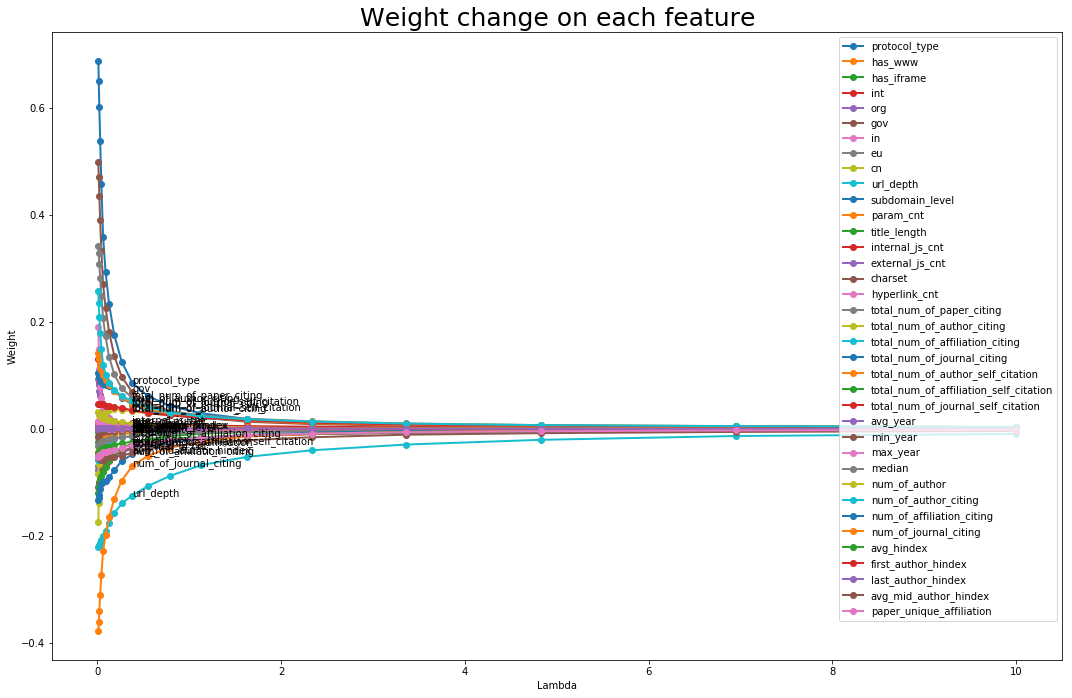

In [14]:
Visualizer.plot_importance_trending(X_train, performance_matrix, 'Weight change on each feature', 10)

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

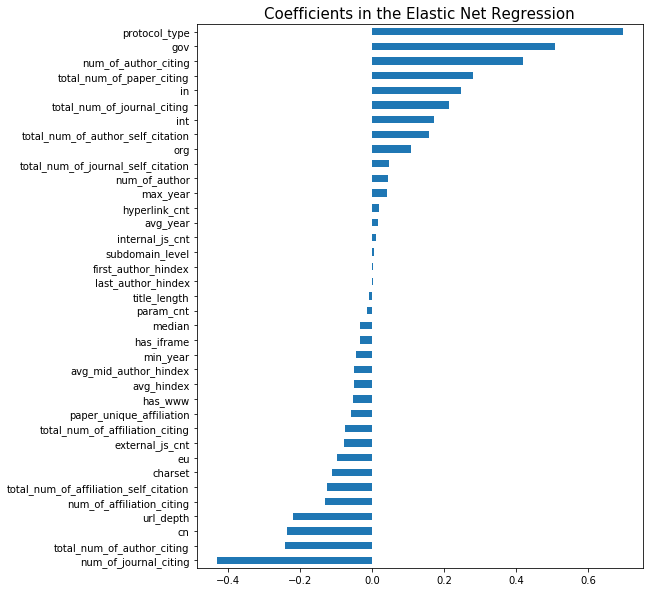

In [15]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train.columns, 
    "Coefficients in the Elastic Net Regression")

#### 2nd Edition - Lasso Regression to Select Features

In [16]:
from sklearn.linear_model import Lasso


start_time = time.time()
param_lso = {
    'alpha': sorted(np.logspace(-2, -1, 20)),
    'max_iter': np.arange(10,80,40),
}


lso = Lasso(random_state=seed)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_lso) \
    .set_engine(lso) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 00 minutes, 5.82 seconds ---


In [17]:
performance_matrix = build_visualization_matrix(result_train, result_test)

In [18]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [19]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

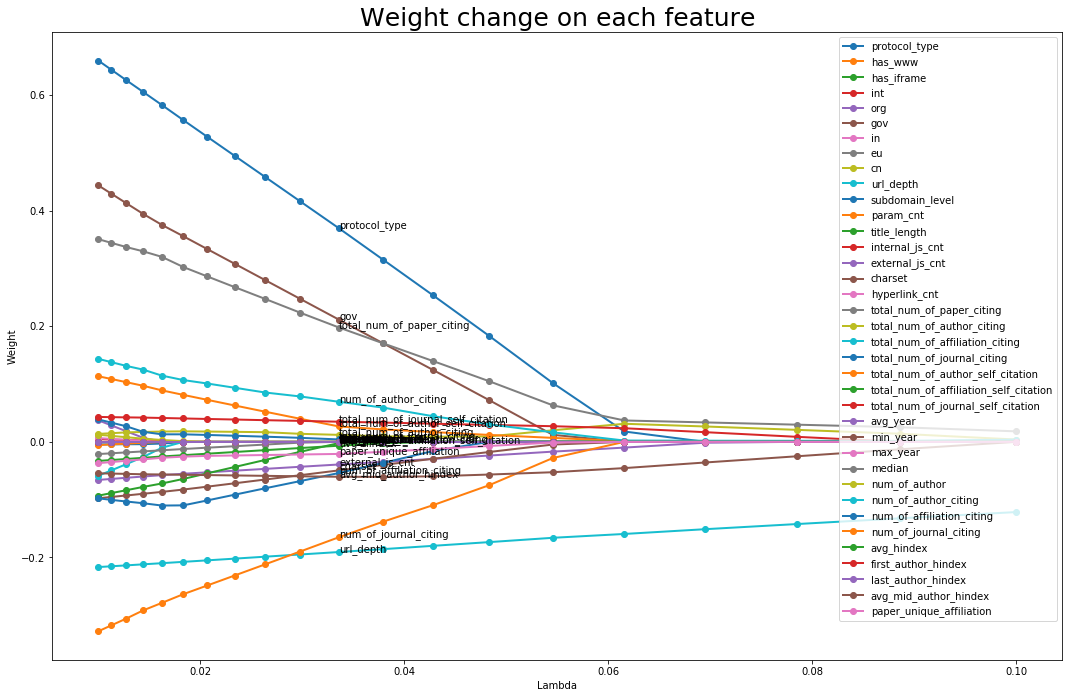

In [20]:
Visualizer.plot_importance_trending(X_train, performance_matrix, 'Weight change on each feature', 10)

In [21]:
start_time = time.time()
param_lso = {
    'alpha': [0.059],
    'max_iter': np.arange(10,80,40),
}


lso = Lasso(random_state=seed)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_lso) \
    .set_engine(lso) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 1.56%


Coefficients  Standard Errors  \
Constant                                      2.2373            0.117   
protocol_type                                 0.0477            0.089   
total_num_of_paper_citing                     0.0375            0.150   
total_num_of_author_citing                    0.0335            0.143   
total_num_of_journal_self_citation            0.0252            0.027   
total_num_of_author_self_citation             0.0035            0.044   
num_of_author_citing                          0.0016            0.145   
int                                           0.0000            0.170   
org                                           0.0000            0.065   
last_author_hindex                            0.0000            0.015   
first_author_hindex                           0.0000            0.015   
avg_hindex                                   -0.0000            0.037   
num_of_journal_citing                        -0.0000            0.069   
num_of_affiliation_citing                    -0.0000            0.107   
num_of_author                                 0.0000            0.039   
median                                       -0.0000            0.025   
max_year                                     -0.0000            2.428   
min_year                                     -0.0000            0.526   
avg_year                                     -0.0000            2.751   
total_num_of_affiliation_self_citation       -0.0000            0.043   
total_num_of_journal_citing                   0.0000            0.166   
total_num_of_affiliation_citing              -0.0000            0.131   
has_www                                      -0.0000            0.057   
gov                                           0.0000            0.077   
in                                            0.0000            0.245   
eu                                           -0.0000            0.174   
cn                                           -0.0000            0.244   
subdomain_level                              -0.0000            0.029   
param_cnt                                    -0.0000            0.025   
title_length                                  0.0000            0.028   
internal_js_cnt                               0.0000            0.028   
charset                                      -0.0000            0.028   
hyperlink_cnt                                 0.0000            0.027   
has_iframe                                    0.0000            0.081   
paper_unique_affiliation                     -0.0000            0.036   
external_js_cnt                              -0.0124            0.028   
avg_mid_author_hindex                        -0.0487            0.033   
url_depth                                    -0.1617            0.027   

                                        t values  Probabilities  
Constant                                  19.159          0.000  
protocol_type                              0.537          0.591  
total_num_of_paper_citing                  0.250          0.802  
total_num_of_author_citing                 0.235          0.815  
total_num_of_journal_self_citation         0.948          0.343  
total_num_of_author_self_citation          0.079          0.937  
num_of_author_citing                       0.011          0.991  
int                                        0.000          1.000  
org                                        0.000          1.000  
last_author_hindex                         0.000          1.000  
first_author_hindex                        0.000          1.000  
avg_hindex                                -0.000          1.000  
num_of_journal_citing                     -0.000          1.000  
num_of_affiliation_citing                 -0.000          1.000  
num_of_author                              0.000          1.000  
median                                    -0.000          1.000  
max_year                                  -0.000          1.000  
min_


R^2 on Testing Set: 1.07%


Coefficients  Standard Errors  \
Constant                                      2.2373            0.170   
protocol_type                                 0.0477            0.129   
total_num_of_paper_citing                     0.0375            0.306   
total_num_of_author_citing                    0.0335            0.152   
total_num_of_journal_self_citation            0.0252            0.041   
total_num_of_author_self_citation             0.0035            0.070   
num_of_author_citing                          0.0016            0.149   
int                                           0.0000            0.261   
org                                           0.0000            0.098   
last_author_hindex                            0.0000            0.024   
first_author_hindex                           0.0000            0.024   
avg_hindex                                   -0.0000            0.057   
num_of_journal_citing                        -0.0000            0.099   
num_of_affiliation_citing                    -0.0000            0.165   
num_of_author                                 0.0000            0.076   
median                                       -0.0000            0.038   
max_year                                     -0.0000            3.649   
min_year                                     -0.0000            0.749   
avg_year                                     -0.0000            4.132   
total_num_of_affiliation_self_citation       -0.0000            0.078   
total_num_of_journal_citing                   0.0000            0.320   
total_num_of_affiliation_citing              -0.0000            0.223   
has_www                                      -0.0000            0.086   
gov                                           0.0000            0.118   
in                                            0.0000            0.389   
eu                                           -0.0000            0.301   
cn                                           -0.0000            0.353   
subdomain_level                              -0.0000            0.044   
param_cnt                                    -0.0000            0.038   
title_length                                  0.0000            0.042   
internal_js_cnt                               0.0000            0.043   
charset                                      -0.0000            0.042   
hyperlink_cnt                                 0.0000            0.039   
has_iframe                                    0.0000            0.121   
paper_unique_affiliation                     -0.0000            0.071   
external_js_cnt                              -0.0124            0.042   
avg_mid_author_hindex                        -0.0487            0.050   
url_depth                                    -0.1617            0.040   

                                        t values  Probabilities  
Constant                                  13.167          0.000  
protocol_type                              0.370          0.711  
total_num_of_paper_citing                  0.123          0.902  
total_num_of_author_citing                 0.220          0.826  
total_num_of_journal_self_citation         0.616          0.538  
total_num_of_author_self_citation          0.050          0.960  
num_of_author_citing                       0.011          0.992  
int                                        0.000          1.000  
org                                        0.000          1.000  
last_author_hindex                         0.000          1.000  
first_author_hindex                        0.000          1.000  
avg_hindex                                -0.000          1.000  
num_of_journal_citing                     -0.000          1.000  
num_of_affiliation_citing                 -0.000          1.000  
num_of_author                              0.000          1.000  
median                                    -0.000          1.000  
max_year                                  -0.000          1.000  
min_

--- 00 minutes, 0.35 seconds ---


In [22]:
rpt = result_test.best_result.rpt


In [23]:
rpt[rpt.Coefficients == 0]

Coefficients  Standard Errors  \
int                                              0.0            0.261   
org                                              0.0            0.098   
last_author_hindex                               0.0            0.024   
first_author_hindex                              0.0            0.024   
avg_hindex                                      -0.0            0.057   
num_of_journal_citing                           -0.0            0.099   
num_of_affiliation_citing                       -0.0            0.165   
num_of_author                                    0.0            0.076   
median                                          -0.0            0.038   
max_year                                        -0.0            3.649   
min_year                                        -0.0            0.749   
avg_year                                        -0.0            4.132   
total_num_of_affiliation_self_citation          -0.0            0.078   
total_num_of_journal_citing                      0.0            0.320   
total_num_of_affiliation_citing                 -0.0            0.223   
has_www                                         -0.0            0.086   
gov                                              0.0            0.118   
in                                               0.0            0.389   
eu                                              -0.0            0.301   
cn                                              -0.0            0.353   
subdomain_level                                 -0.0            0.044   
param_cnt                                       -0.0            0.038   
title_length                                     0.0            0.042   
internal_js_cnt                                  0.0            0.043   
charset                                         -0.0            0.042   
hyperlink_cnt                                    0.0            0.039   
has_iframe                                       0.0            0.121   
paper_unique_affiliation                        -0.0            0.071   

                                        t values  Probabilities  
int                                          0.0            1.0  
org                                          0.0            1.0  
last_author_hindex                           0.0            1.0  
first_author_hindex                          0.0            1.0  
avg_hindex                                  -0.0            1.0  
num_of_journal_citing                       -0.0            1.0  
num_of_affiliation_citing                   -0.0            1.0  
num_of_author                                0.0            1.0  
median                                      -0.0            1.0  
max_year                                    -0.0            1.0  
min_year                                    -0.0            1.0  
avg_year                                    -0.0            1.0  
total_num_of_affiliation_self_citation      -0.0            1.0  
total_num_of_journal_citing                  0.0            1.0  
total_num_of_affiliation_citing             -0.0            1.0  
has_www                                     -0.0            1.0  
gov                                          0.0            1.0  
in                                           0.0            1.0  
eu                                          -0.0            1.0  
cn                                          -0.0            1.0  
subdomain_level                             -0.0            1.0  
param_cnt                                   -0.0            1.0  
title_length                                 0.0            1.0  
internal_js_cnt                              0.0            1.0  
charset                                     -0.0            1.0  
hyperlink_cnt                                0.0            1.0  
has_iframe                                   0.0            1.0  
paper_unique_affiliation                    -0.0            1.0

In [24]:
rpt.sort_values(by=['Probabilities', 'Standard Errors'])

Coefficients  Standard Errors  \
url_depth                                    -0.1617            0.040   
Constant                                      2.2373            0.170   
avg_mid_author_hindex                        -0.0487            0.050   
total_num_of_journal_self_citation            0.0252            0.041   
protocol_type                                 0.0477            0.129   
external_js_cnt                              -0.0124            0.042   
total_num_of_author_citing                    0.0335            0.152   
total_num_of_paper_citing                     0.0375            0.306   
total_num_of_author_self_citation             0.0035            0.070   
num_of_author_citing                          0.0016            0.149   
last_author_hindex                            0.0000            0.024   
first_author_hindex                           0.0000            0.024   
median                                       -0.0000            0.038   
param_cnt                                    -0.0000            0.038   
hyperlink_cnt                                 0.0000            0.039   
title_length                                  0.0000            0.042   
charset                                      -0.0000            0.042   
internal_js_cnt                               0.0000            0.043   
subdomain_level                              -0.0000            0.044   
avg_hindex                                   -0.0000            0.057   
paper_unique_affiliation                     -0.0000            0.071   
num_of_author                                 0.0000            0.076   
total_num_of_affiliation_self_citation       -0.0000            0.078   
has_www                                      -0.0000            0.086   
org                                           0.0000            0.098   
num_of_journal_citing                        -0.0000            0.099   
gov                                           0.0000            0.118   
has_iframe                                    0.0000            0.121   
num_of_affiliation_citing                    -0.0000            0.165   
total_num_of_affiliation_citing              -0.0000            0.223   
int                                           0.0000            0.261   
eu                                           -0.0000            0.301   
total_num_of_journal_citing                   0.0000            0.320   
cn                                           -0.0000            0.353   
in                                            0.0000            0.389   
min_year                                     -0.0000            0.749   
max_year                                     -0.0000            3.649   
avg_year                                     -0.0000            4.132   

                                        t values  Probabilities  
url_depth                                 -4.024          0.000  
Constant                                  13.167          0.000  
avg_mid_author_hindex                     -0.973          0.331  
total_num_of_journal_self_citation         0.616          0.538  
protocol_type                              0.370          0.711  
external_js_cnt                           -0.297          0.766  
total_num_of_author_citing                 0.220          0.826  
total_num_of_paper_citing                  0.123          0.902  
total_num_of_author_self_citation          0.050          0.960  
num_of_author_citing                       0.011          0.992  
last_author_hindex                         0.000          1.000  
first_author_hindex                        0.000          1.000  
median                                    -0.000          1.000  
param_cnt                                 -0.000          1.000  
hyperlink_cnt                              0.000          1.000  
title_length                               0.000          1.000  
charset                                   -0.000          1.000  
inte

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

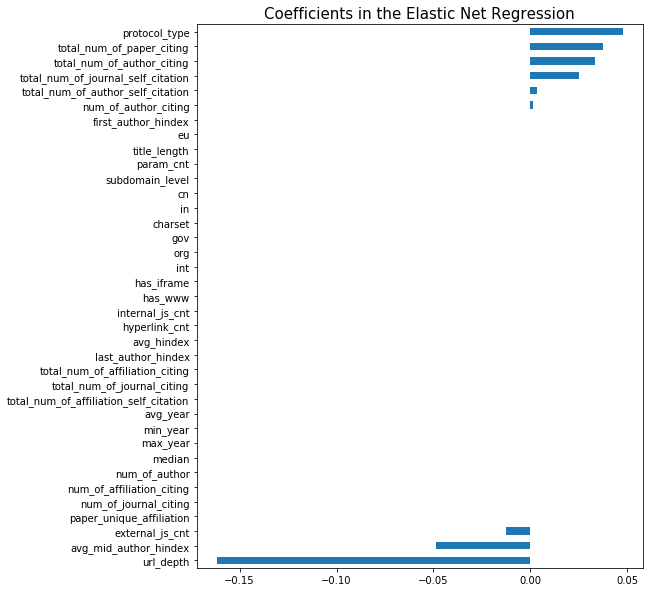

In [25]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train.columns, 
    "Coefficients in the Elastic Net Regression")

#### 3rd Edition - Use Selected Features to run Lasso Regression Again

- Manually select features

In [26]:
features = set(tuple([
    'org',
    'gov',
    'int',
    'in',
    'cn',
    'eu',
]))

for col_name in rpt[rpt.Coefficients != 0].index.tolist():
    features.add(col_name)

features.remove('Constant')

In [27]:
features

{'avg_mid_author_hindex',
 'cn',
 'eu',
 'external_js_cnt',
 'gov',
 'in',
 'int',
 'num_of_author_citing',
 'org',
 'protocol_type',
 'total_num_of_author_citing',
 'total_num_of_author_self_citation',
 'total_num_of_journal_self_citation',
 'total_num_of_paper_citing',
 'url_depth'}

In [28]:
start_time = time.time()
param_lso = {
    'alpha': sorted(np.logspace(-2, -1, 20)),
    'max_iter': np.arange(10,80,40),
}


lso = Lasso(random_state=seed)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train[features]) \
    .set_y_train(y_train) \
    .set_X_test(X_test[features]) \
    .set_y_test(y_test) \
    .set_param_grid(param_lso) \
    .set_engine(lso) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 00 minutes, 4.50 seconds ---


In [29]:
performance_matrix = build_visualization_matrix(result_train, result_test)

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

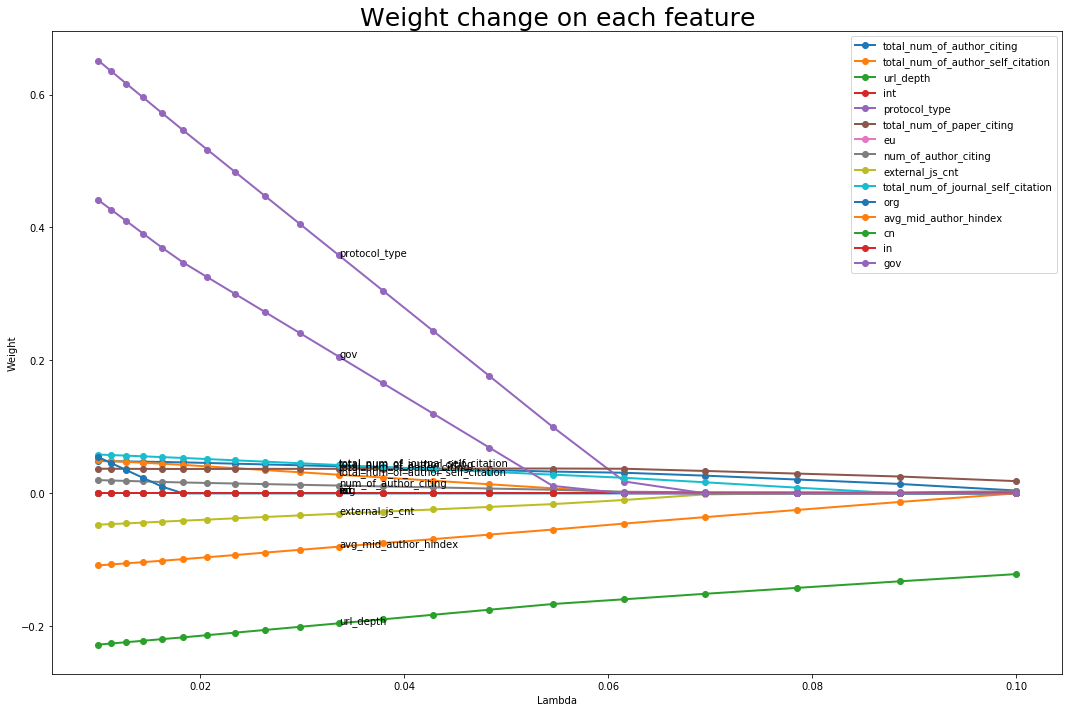

In [30]:
Visualizer.plot_importance_trending(X_train[features], performance_matrix, 'Weight change on each feature', 10)

In [31]:
start_time = time.time()
param_lso = {
    'alpha': [0.059],
    'max_iter': np.arange(10,80,40),
}


lso = Lasso(random_state=seed)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train[features]) \
    .set_y_train(y_train) \
    .set_X_test(X_test[features]) \
    .set_y_test(y_test) \
    .set_param_grid(param_lso) \
    .set_engine(lso) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 1.56%


Coefficients  Standard Errors  t values  \
Constant                                  2.2373            0.087    25.680   
protocol_type                             0.0477            0.087     0.547   
total_num_of_paper_citing                 0.0376            0.040     0.933   
total_num_of_author_citing                0.0335            0.102     0.328   
total_num_of_journal_self_citation        0.0251            0.026     0.962   
total_num_of_author_self_citation         0.0035            0.032     0.110   
num_of_author_citing                      0.0015            0.111     0.013   
int                                       0.0000            0.169     0.000   
eu                                       -0.0000            0.173    -0.000   
org                                       0.0000            0.060     0.000   
cn                                       -0.0000            0.242    -0.000   
in                                        0.0000            0.243     0.000   
gov                                       0.0000            0.076     0.000   
external_js_cnt                          -0.0123            0.025    -0.488   
avg_mid_author_hindex                    -0.0487            0.027    -1.829   
url_depth                                -0.1618            0.026    -6.292   

                                    Probabilities  
Constant                                    0.000  
protocol_type                               0.585  
total_num_of_paper_citing                   0.351  
total_num_of_author_citing                  0.743  
total_num_of_journal_self_citation          0.336  
total_num_of_author_self_citation           0.913  
num_of_author_citing                        0.989  
int                                         1.000  
eu                                          1.000  
org                                         1.000  
cn                                          1.000  
in                                          1.000  
gov                                         1.000  
external_js_cnt                             0.625  
avg_mid_author_hindex                       0.067  
url_depth                                   0.000


R^2 on Testing Set: 1.07%


Coefficients  Standard Errors  t values  \
Constant                                  2.2373            0.127    17.624   
protocol_type                             0.0477            0.126     0.378   
total_num_of_paper_citing                 0.0376            0.063     0.600   
total_num_of_author_citing                0.0335            0.099     0.337   
total_num_of_journal_self_citation        0.0251            0.040     0.630   
total_num_of_author_self_citation         0.0035            0.050     0.070   
num_of_author_citing                      0.0015            0.111     0.013   
int                                       0.0000            0.258     0.000   
eu                                       -0.0000            0.299    -0.000   
org                                       0.0000            0.089     0.000   
cn                                       -0.0000            0.348    -0.000   
in                                        0.0000            0.387     0.000   
gov                                       0.0000            0.114     0.000   
external_js_cnt                          -0.0123            0.038    -0.325   
avg_mid_author_hindex                    -0.0487            0.040    -1.220   
url_depth                                -0.1618            0.039    -4.172   

                                    Probabilities  
Constant                                    0.000  
protocol_type                               0.706  
total_num_of_paper_citing                   0.549  
total_num_of_author_citing                  0.736  
total_num_of_journal_self_citation          0.529  
total_num_of_author_self_citation           0.945  
num_of_author_citing                        0.989  
int                                         1.000  
eu                                          1.000  
org                                         1.000  
cn                                          1.000  
in                                          1.000  
gov                                         1.000  
external_js_cnt                             0.745  
avg_mid_author_hindex                       0.222  
url_depth                                   0.000

--- 00 minutes, 0.33 seconds ---


In [32]:
rpt = result_test.best_result.rpt


In [33]:
rpt[rpt.Coefficients == 0]

Coefficients  Standard Errors  t values  Probabilities
int           0.0            0.258       0.0            1.0
eu           -0.0            0.299      -0.0            1.0
org           0.0            0.089       0.0            1.0
cn           -0.0            0.348      -0.0            1.0
in            0.0            0.387       0.0            1.0
gov           0.0            0.114       0.0            1.0

In [34]:
rpt.sort_values(by=['Probabilities', 'Standard Errors'])

Coefficients  Standard Errors  t values  \
url_depth                                -0.1618            0.039    -4.172   
Constant                                  2.2373            0.127    17.624   
avg_mid_author_hindex                    -0.0487            0.040    -1.220   
total_num_of_journal_self_citation        0.0251            0.040     0.630   
total_num_of_paper_citing                 0.0376            0.063     0.600   
protocol_type                             0.0477            0.126     0.378   
total_num_of_author_citing                0.0335            0.099     0.337   
external_js_cnt                          -0.0123            0.038    -0.325   
total_num_of_author_self_citation         0.0035            0.050     0.070   
num_of_author_citing                      0.0015            0.111     0.013   
org                                       0.0000            0.089     0.000   
gov                                       0.0000            0.114     0.000   
int                                       0.0000            0.258     0.000   
eu                                       -0.0000            0.299    -0.000   
cn                                       -0.0000            0.348    -0.000   
in                                        0.0000            0.387     0.000   

                                    Probabilities  
url_depth                                   0.000  
Constant                                    0.000  
avg_mid_author_hindex                       0.222  
total_num_of_journal_self_citation          0.529  
total_num_of_paper_citing                   0.549  
protocol_type                               0.706  
total_num_of_author_citing                  0.736  
external_js_cnt                             0.745  
total_num_of_author_self_citation           0.945  
num_of_author_citing                        0.989  
org                                         1.000  
gov                                         1.000  
int                                         1.000  
eu                                          1.000  
cn                                          1.000  
in                                          1.000

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

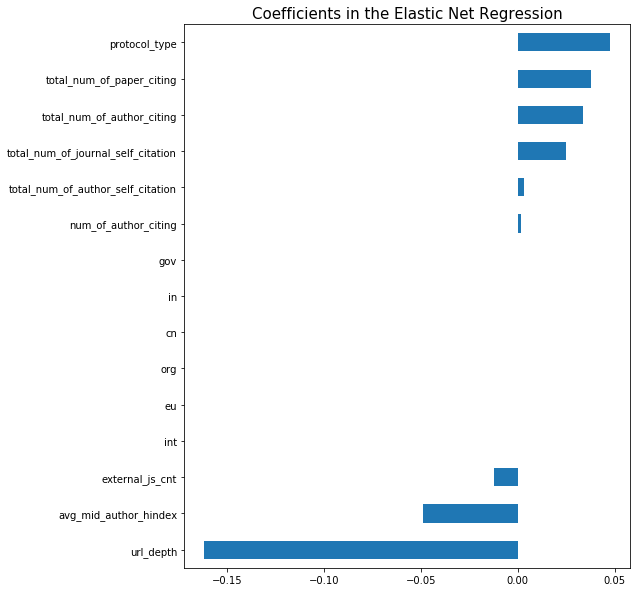

In [35]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train[features].columns, 
    "Coefficients in the Elastic Net Regression")

#### 4th Edition - Retrain the Elastic Net Regressor with Selected Features

In [36]:
features = rpt[rpt.Coefficients != 0].index.tolist()[1:]
features

['protocol_type',
 'total_num_of_paper_citing',
 'total_num_of_author_citing',
 'total_num_of_journal_self_citation',
 'total_num_of_author_self_citation',
 'num_of_author_citing',
 'external_js_cnt',
 'avg_mid_author_hindex',
 'url_depth']

In [37]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train[features]) \
    .set_y_train(y_train) \
    .set_X_test(X_test[features]) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 00 minutes, 24.54 seconds ---


In [38]:
performance_matrix = build_visualization_matrix(result_train, result_test)

In [39]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [40]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

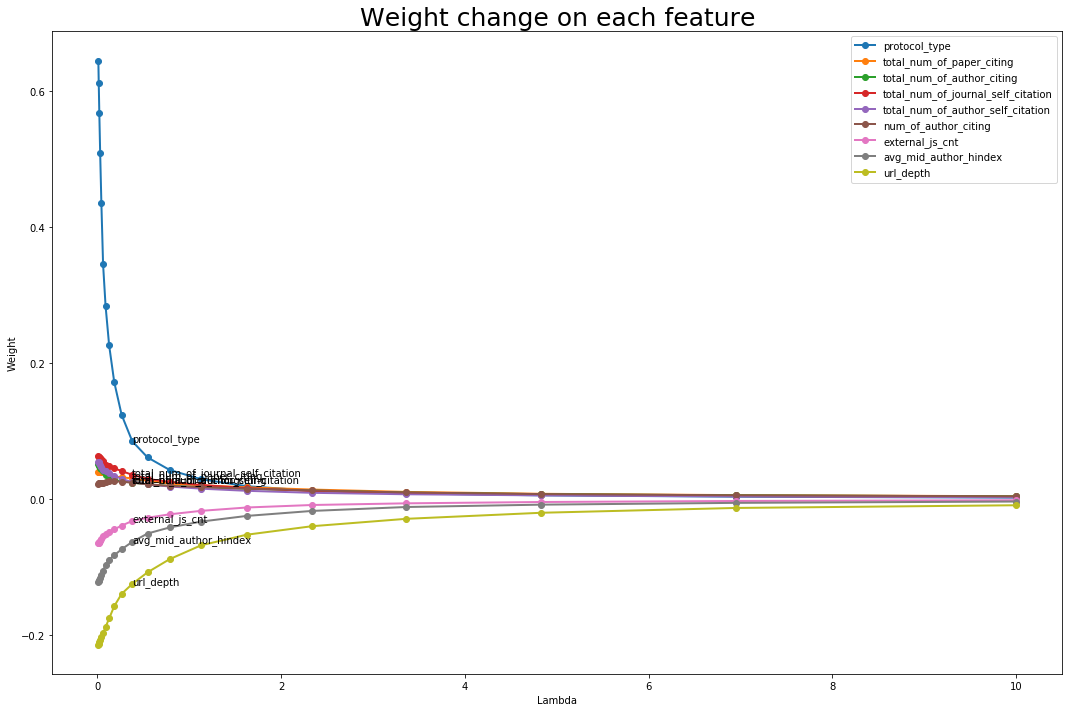

In [41]:
Visualizer.plot_importance_trending(X_train[features], performance_matrix, 'Weight change on each feature', 10)

In [42]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train[features]) \
    .set_y_train(y_train) \
    .set_X_test(X_test[features]) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 2.71%


Coefficients  Standard Errors  t values  \
Constant                                  1.7238            0.082    20.960   
protocol_type                             0.6133            0.086     7.104   
total_num_of_journal_self_citation        0.0626            0.026     2.414   
total_num_of_author_citing                0.0590            0.101     0.582   
total_num_of_author_self_citation         0.0546            0.031     1.742   
total_num_of_paper_citing                 0.0404            0.040     1.011   
num_of_author_citing                      0.0142            0.110     0.129   
external_js_cnt                          -0.0645            0.025    -2.580   
avg_mid_author_hindex                    -0.1216            0.026    -4.598   
url_depth                                -0.2128            0.025    -8.504   

                                    Probabilities  
Constant                                    0.000  
protocol_type                               0.000  
total_num_of_journal_self_citation          0.016  
total_num_of_author_citing                  0.561  
total_num_of_author_self_citation           0.081  
total_num_of_paper_citing                   0.312  
num_of_author_citing                        0.897  
external_js_cnt                             0.010  
avg_mid_author_hindex                       0.000  
url_depth                                   0.000


R^2 on Testing Set: 1.63%


Coefficients  Standard Errors  t values  \
Constant                                  1.7238            0.119    14.535   
protocol_type                             0.6133            0.125     4.902   
total_num_of_journal_self_citation        0.0626            0.040     1.576   
total_num_of_author_citing                0.0590            0.099     0.597   
total_num_of_author_self_citation         0.0546            0.049     1.103   
total_num_of_paper_citing                 0.0404            0.062     0.648   
num_of_author_citing                      0.0142            0.110     0.129   
external_js_cnt                          -0.0645            0.038    -1.715   
avg_mid_author_hindex                    -0.1216            0.040    -3.060   
url_depth                                -0.2128            0.038    -5.643   

                                    Probabilities  
Constant                                    0.000  
protocol_type                               0.000  
total_num_of_journal_self_citation          0.115  
total_num_of_author_citing                  0.551  
total_num_of_author_self_citation           0.270  
total_num_of_paper_citing                   0.517  
num_of_author_citing                        0.897  
external_js_cnt                             0.086  
avg_mid_author_hindex                       0.002  
url_depth                                   0.000

--- 00 minutes, 16.94 seconds ---


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

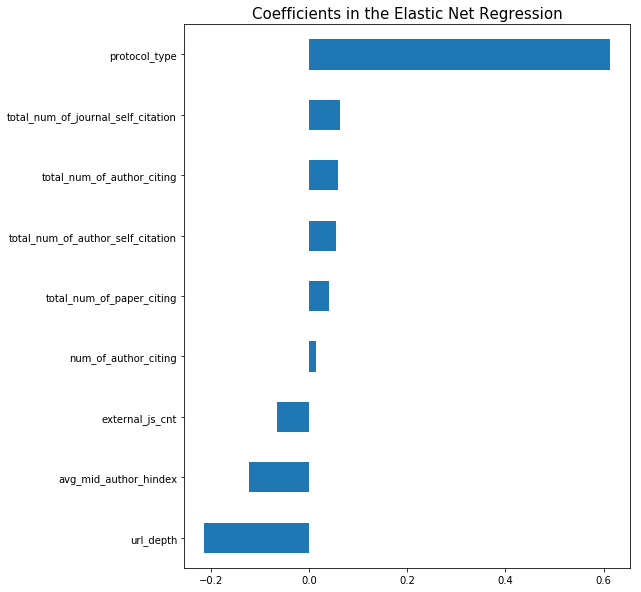

In [43]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train[features].columns, 
    "Coefficients in the Elastic Net Regression")